# Creating player_centric features from games

In [1]:
# Simple Chess Player Types Analysis
# For "Game-based quantification of chess player types" Master Thesis

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

# Set the style for our plots
plt.style.use('ggplot')
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

# --------------------------------------------------
# 1. LOAD DATA AND TRANSFORM TO PLAYER-CENTRIC FORMAT
# --------------------------------------------------

# Load the dataset
file_path = '../data/processed/lumbrasgigabase/only_book/chess_games_with_feats.csv'
chess_df = pd.read_csv(file_path)

# drop where result_category is Draw
# chess_df = chess_df[chess_df['result_category'] != 'Draw']
# chess_df.reset_index(drop=True, inplace=True)
# print(f"Loaded dataset with shape: {chess_df.shape}")


# change names of same players to the same name
name_changes = {
    "Kasparov, G.": "Kasparov, Garry",
    "Kasparov,G": "Kasparov, Garry",
    "Kasparov, G": "Kasparov, Garry",
    "Spassky, Boris Vasilievich": "Spassky, Boris V.",
    "Anand,V": "Anand, Viswanathan",
    "Larsen, B.": "Larsen, Bent",
    "Botvinnik, M.": "Botvinnik, Mikhail URS",
    "Moskalenko, Viktor1": "Moskalenko, Viktor",
    "Moskalenko, V.": "Moskalenko, Viktor",
    "Smyslov, V.": "Smyslov",
    "Petrosian, T.": "Petrosian",
    "Karpov, A.": "Karpov, Anatoly",
    "Bischoff,K": "Bischoff, K.",
    "Fischer, R.": "Fischer",
}

def replace_name(name):
    return name_changes.get(name, name)

chess_df['white'] = chess_df['white'].apply(replace_name)
chess_df['black'] = chess_df['black'].apply(replace_name)

print(f"Original dataset shape: {chess_df.shape}")

# Define known player types from the book
activist_players = [
    "Alekhine, Alexander", "Tal, Mikhail", "Spassky, Boris V.",
    "Kasparov, Garry", "Anand, Viswanathan", "Shirov, Alexei",
    "Morozevich, Alexander", "Topalov, Veselin", "Pillsbury, Harry",
    "Anderssen, Adolf", "Bronstein, David I", "Bronstein, Luis Marcos",
    "Larsen, Bent", "Taimanov, Mark E", "Aronian, Levon",
    "Polgar, Judit", "Muller, K."
]

theorist_players = [
    "Steinitz, Wilhelm", "Botvinnik, Mikhail URS", "Kramnik, Vladimir", "Tarrasch, Siegbert",
    "Nimzowitsch, Aron", "Leko, Peter", "Giri, Anish", "Meier, Georg",
    "Andersson, Ulf", "Sedlak, Nikola", "Tiviakov, Sergei", "Ponomariov, Ruslan",
    "Wahls, Matthias", "Moskalenko, Viktor", "Dorfman, Iossif", "Bangiev, Alexander", "Hansen, Lars Bo"
]

reflector_players = [
    "Capablanca, Jose", "Smyslov", "Petrosian", 
    "Karpov, Anatoly", "Carlsen, Magnus", "Adams, Michael", "Keymer, Vincent",
    "Bischoff, K."
]

pragmatist_players = [
    "Fischer", "Euwe, Max", "Korchnoi, Viktor", "Caruana, Fabiano",
    "Ding, Liren", "Karjakin, Sergey", "Vachier-Lagrave, Maxime"
]





# Create a dictionary mapping player names to their types
player_type_map = {}
for player in activist_players:
    player_type_map[player] = "Activist"
for player in theorist_players:
    player_type_map[player] = "Theorist"  
for player in reflector_players:
    player_type_map[player] = "Reflector"
for player in pragmatist_players:
    player_type_map[player] = "Pragmatist"

# Identify categorical, identifier, and numerical features
categorical_cols = ['event', 'site', 'date', 'round', 'white', 'black', 'result',
                   'white_title', 'black_title', 'eco', 'opening', 'result_category', 
                   'eco_family', 'opening_name']
identifier_cols = ['white_elo', 'black_elo', 'year']

# Get all columns, then remove categorical and identifier columns to get numerical features
all_cols = chess_df.columns.tolist()
numerical_features = [col for col in all_cols if col not in categorical_cols and col not in identifier_cols]

# Create a dataframe with just the numerical features for analysis
numerical_df = chess_df[numerical_features].copy()

# Split features into white-specific, black-specific, and common
white_features = [col for col in numerical_features if col.startswith('white_')]
black_features = [col for col in numerical_features if col.startswith('black_')]
common_features = [col for col in numerical_features if not col.startswith('white_') and not col.startswith('black_')]

print(f"\nFeature distribution:")
print(f"White player features: {len(white_features)}")
print(f"Black player features: {len(black_features)}")
print(f"Common game features: {len(common_features)}")

# --------------------------------------------------
# 2. CREATE PLAYER-CENTRIC DATAFRAME
# --------------------------------------------------

# Define phase-specific features where 0 means "phase not played"
phase_specific_features = [
    'white_opening_accuracy', 'white_middlegame_accuracy', 'white_endgame_accuracy',
    'black_opening_accuracy', 'black_middlegame_accuracy', 'black_endgame_accuracy'
]

# Create two new dataframes for players
players_data = []

# Process white players
for i, row in chess_df.iterrows():
    player_data = {}
    
    # Add player info
    player_data['player_name'] = row['white'] if 'white' in chess_df.columns else f"White_Player_{i}"
    player_data['player_color'] = 'white'
    player_data['opponent_name'] = row['black'] if 'black' in chess_df.columns else f"Black_Player_{i}"
    player_data['player_elo'] = row['white_elo'] if 'white_elo' in chess_df.columns else None
    player_data['date'] = row['date'] if 'date' in chess_df.columns else None
    player_data['eco'] = row['eco'] if 'eco' in chess_df.columns else None
    player_data['eco_family'] = row['eco_family'] if 'eco_family' in chess_df.columns else None
    player_data['opening_name'] = row['opening_name'] if 'opening_name' in chess_df.columns else None
    
    # Add player type if known
    if 'white' in chess_df.columns and row['white'] in player_type_map:
        player_data['player_type'] = player_type_map[row['white']]
    else:
        player_data['player_type'] = None
    
    # Add game identifiers
    player_data['game_id'] = i
    if 'result' in chess_df.columns:
        player_data['result'] = row['result']
    
    # Add player-specific features (removing the prefix)
    for feature in white_features:
        feature_name = feature.replace('white_', '')
        value = numerical_df.iloc[i][feature]
        

        player_data[feature_name] = value
    
    # Add common features
    for feature in common_features:
        player_data[feature] = numerical_df.iloc[i][feature]
    
    players_data.append(player_data)

# Process black players
for i, row in chess_df.iterrows():
    player_data = {}
    
    # Add player info
    player_data['player_name'] = row['black'] if 'black' in chess_df.columns else f"Black_Player_{i}"
    player_data['player_color'] = 'black'
    player_data['opponent_name'] = row['white'] if 'white' in chess_df.columns else f"White_Player_{i}"
    player_data['player_elo'] = row['black_elo'] if 'black_elo' in chess_df.columns else None
    player_data['date'] = row['date'] if 'date' in chess_df.columns else None
    player_data['eco'] = row['eco'] if 'eco' in chess_df.columns else None
    player_data['eco_family'] = row['eco_family'] if 'eco_family' in chess_df.columns else None
    player_data['opening_name'] = row['opening_name'] if 'opening_name' in chess_df.columns else None
    
    # Add player type if known
    if 'black' in chess_df.columns and row['black'] in player_type_map:
        player_data['player_type'] = player_type_map[row['black']]
    else:
        player_data['player_type'] = None
    
    # Add game identifiers
    player_data['game_id'] = i
    if 'result' in chess_df.columns:
        player_data['result'] = row['result']
    
    # Add player-specific features (removing the prefix)
    for feature in black_features:
        feature_name = feature.replace('black_', '')
        value = numerical_df.iloc[i][feature]
        

        player_data[feature_name] = value
    
    # Add common features
    for feature in common_features:
        player_data[feature] = numerical_df.iloc[i][feature]
    
    players_data.append(player_data)

# Convert to dataframe
players_df = pd.DataFrame(players_data)




print(f"\nPlayer-centric dataset shape: {players_df.shape}")
print(f"This represents {chess_df.shape[0]} games × 2 players = {chess_df.shape[0]*2} player instances")

# Count players with known types
known_types_count = players_df['player_type'].notna().sum()
print(f"\nPlayers with known types in dataset: {known_types_count} ({known_types_count/len(players_df)*100:.2f}%)")

# Count by type
if known_types_count > 0:
    type_counts = players_df['player_type'].value_counts()
    print("\nDistribution of known player types:")
    print(type_counts)


# Save the player-centric dataframe for future use
players_df.to_csv('player_centric_data.csv', index=False)
print("\nSaved player-centric data to 'player_centric_data.csv'")

Original dataset shape: (49711, 85)

Feature distribution:
White player features: 31
Black player features: 31
Common game features: 6

Player-centric dataset shape: (99422, 48)
This represents 49711 games × 2 players = 99422 player instances

Players with known types in dataset: 53999 (54.31%)

Distribution of known player types:
player_type
Theorist      17323
Activist      16388
Pragmatist    10319
Reflector      9969
Name: count, dtype: int64

Saved player-centric data to 'player_centric_data.csv'


# Feature analysis

In [2]:
# Chess Player Type Analysis - Feature Exploration
# Based on the thesis: "Game-based quantification of chess player types"

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.impute import SimpleImputer
from scipy import stats
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# Set the style for our visualizations
plt.style.use('fivethirtyeight')
sns.set_palette("viridis")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Load the dataset
df = pd.read_csv('player_centric_data.csv')

# Display basic information about the dataset
print(f"Dataset Shape: {df.shape}")
print("\nFirst few rows:")
display(df.head())

# Check for missing values
missing_values = df.isnull().sum()
print("\nMissing Values:")
display(missing_values[missing_values > 0])

# Basic statistics of numerical features
print("\nBasic Statistics:")
display(df.describe())

Dataset Shape: (99422, 48)

First few rows:


,player_name,player_color,opponent_name,player_elo,date,eco,eco_family,opening_name,player_type,game_id,...,blunder_count,top_move_alignment,top2_3_move_alignment,sharpness,total_moves,opening_length,middlegame_length,endgame_length,material_balance_std,opening_novelty_score
0,"Kupreichik, Viktor D",white,"Tal, Mikhail",2540.0,1979-12-01,B97,B,"Sicilian Defense: Najdorf Variation, Poisoned ...",NaN,0,...,0.000000,0.700000,0.220000,2.501763,50,0.240000,0.320000,0.440000,1.319810592471511,0.583333
1,"Keres, Paul",white,"Tal, Mikhail",NaN,1961-10-16,D30,D,Queen's Gambit Declined: Capablanca Variation,NaN,1,...,0.000000,0.315789,0.473684,1.501872,19,0.736842,0.263158,0.000000,1.8029123929484048,0.214286
2,"Tal, Mikhail",white,"Keene, Raymond D",NaN,1964-01-10,B15,B,Caro-Kann Defense: Alekhine Gambit,Activist,2,...,0.033333,0.533333,0.133333,2.021509,30,0.400000,0.466667,0.133333,1.43158970128661,0.333333
3,"Klovans, Janis",white,"Tal, Mikhail",NaN,1951-01-01,C52,C,"Italian Game: Evans Gambit, Sokolsky Variation",NaN,3,...,0.000000,0.475000,0.200000,8.298026,40,0.175000,0.725000,0.100000,1.791187423277396,1.000000
4,"Tal, Mikhail",white,"Benko, Pal",NaN,1959-01-01,B27,A,Modern Defense: Pterodactyl Variation,Activist,4,...,0.100000,0.433333,0.333333,2.700204,30,0.266667,0.733333,0.000000,1.2310790208412925,0.375000



Missing Values:


player_elo      14956
eco                 4
opening_name        4
player_type     45423
dtype: int64


Basic Statistics:


,player_elo,game_id,minor_piece_development,queen_development,queen_lifetime,castle_move,material_changes,piece_mobility_avg,pawn_structure_changes,pawn_control,...,mistake_count,blunder_count,top_move_alignment,top2_3_move_alignment,sharpness,total_moves,opening_length,middlegame_length,endgame_length,opening_novelty_score
count,84466.000000,99422.000000,99422.000000,99422.000000,99422.000000,99422.000000,99422.000000,99422.000000,99422.000000,99422.000000,...,99422.000000,99422.000000,99422.000000,99422.000000,99422.000000,99422.000000,99422.000000,99422.000000,99422.000000,99422.000000
mean,2612.872647,24855.000000,0.400641,0.383569,0.764755,0.241051,0.105787,96.484689,0.190087,1.526498,...,0.011865,0.007275,0.545822,0.288469,2.742393,39.577558,0.334600,0.433383,0.231977,0.404277
std,172.047141,14350.401782,0.216840,0.231676,0.256726,0.176280,0.028131,33.039210,0.044150,0.101090,...,0.021239,0.019462,0.115513,0.084156,1.323840,14.173828,0.168190,0.179870,0.215141,0.209229
min,700.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-182.000000,0.000000,0.496584,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2533.000000,12427.250000,0.243902,0.214286,0.555556,0.129630,0.088889,75.921946,0.160000,1.464267,...,0.000000,0.000000,0.470588,0.232558,1.938307,30.000000,0.220000,0.298246,0.000000,0.250000
50%,2650.000000,24855.000000,0.339286,0.323529,0.906458,0.209302,0.105263,97.475000,0.186047,1.527396,...,0.000000,0.000000,0.547619,0.285714,2.403732,39.000000,0.292683,0.432432,0.205882,0.368421
75%,2737.000000,37282.750000,0.500000,0.487179,0.976744,0.322581,0.123077,118.771280,0.215686,1.590621,...,0.021277,0.000000,0.625000,0.340426,3.162072,49.000000,0.400000,0.571429,0.412957,0.538462
max,2882.000000,49710.000000,1.000000,1.000000,1.000000,1.000000,0.266667,206.309091,0.600000,1.916667,...,0.500000,0.666667,1.000000,0.875000,18.710319,172.000000,1.000000,0.894737,0.863354,1.000000


In [3]:


# 1. Data Preprocessing

# Define known player types from the book (using the provided mappings)
activist_players = [
    "Alekhine, Alexander", "Tal, Mikhail", "Spassky, Boris V.",
    "Kasparov, Garry", "Anand, Viswanathan", "Shirov, Alexei",
    "Morozevich, Alexander", "Topalov, Veselin", "Pillsbury, Harry",
    "Anderssen, Adolf", "Bronstein, David I", "Bronstein, Luis Marcos",
    "Larsen, Bent", "Taimanov, Mark E", "Aronian, Levon",
    "Polgar, Judit", "Muller, K."
]

theorist_players = [
    "Steinitz, Wilhelm", "Botvinnik, Mikhail URS", "Kramnik, Vladimir", "Tarrasch, Siegbert",
    "Nimzowitsch, Aron", "Leko, Peter", "Giri, Anish", "Meier, Georg",
    "Andersson, Ulf", "Sedlak, Nikola", "Tiviakov, Sergei", "Ponomariov, Ruslan",
    "Wahls, Matthias", "Moskalenko, Viktor", "Dorfman, Iossif", "Bangiev, Alexander", "Hansen, Lars Bo"
]

reflector_players = [
    "Capablanca, Jose", "Smyslov", "Petrosian", 
    "Karpov, Anatoly", "Carlsen, Magnus", "Adams, Michael", "Keymer, Vincent",
    "Bischoff, K."
]

pragmatist_players = [
    "Fischer", "Euwe, Max", "Korchnoi, Viktor", "Caruana, Fabiano",
    "Ding, Liren", "Karjakin, Sergey", "Vachier-Lagrave, Maxime"
]

# Function to map players to their types
def assign_player_types():
    """Assign player types based on the known player classifications"""
    # Create a dictionary mapping player names to their types
    player_type_map = {}
    for player in activist_players:
        player_type_map[player] = "Activist"
    for player in theorist_players:
        player_type_map[player] = "Theorist"
    for player in reflector_players:
        player_type_map[player] = "Reflector"
    for player in pragmatist_players:
        player_type_map[player] = "Pragmatist"
    
    # Apply the mapping to the dataframe
    labeled_count = 0
    
    # Create a list to store player counts for sorting
    player_counts = []
    for player, player_type in player_type_map.items():
        mask = df['player_name'].str.contains(player, case=True, na=False)
        count = mask.sum()
        if count > 0:
            player_counts.append((player, player_type, mask, count))
    
    # Sort by count in descending order
    player_counts.sort(key=lambda x: x[3], reverse=True)
    
    # Apply the player types in order of count
    for player, player_type, mask, count in player_counts:
        df.loc[mask, 'player_type'] = player_type
        labeled_count += count
        print(f"Labeled {count} games for {player} as {player_type}")
    
    print(f"\nTotal labeled games: {labeled_count}")
    print(f"Player type distribution:")
    display(df['player_type'].value_counts())
    
    # Create color-based player type for visualizations
    color_map = {
        'Activist': 'red',
        'Theorist': 'blue',
        'Reflector': 'green',
        'Pragmatist': 'purple'
    }
    
    df['player_type_color'] = df['player_type'].map(color_map)
    
    return labeled_count

# Apply the function to assign player types
labeled_count = assign_player_types()

# 2. Feature Grouping and Selection

# Group features by category for easier analysis
feature_groups = {
    'Opening Features': ['minor_piece_development', 'queen_development', 'castle_move', 'opening_novelty_score', 'opening_accuracy', 'opening_length'],
    'Queen Play': ['queen_lifetime'],
    'Material Handling': ['material_changes', 'material_balance_std'],
    'Positional Features': ['piece_mobility_avg', 'pawn_structure_changes', 'pawn_control', 'center_control_avg', 'space_advantage'],
    'King Safety': ['king_safety', 'vulnerability_spikes', 'check_frequency'],
    'Move Quality': ['accuracy', 'brilliant_count', 'great_count', 'good_moves', 'inaccuracy_count', 'mistake_count', 'blunder_count', 'top_move_alignment', 'top2_3_move_alignment'],
    'Game Phase': ['middlegame_accuracy', 'endgame_accuracy', 'middlegame_length', 'endgame_length'],
    'Strategic Indicators': ['sacrifice_count', 'prophylactic_frequency', 'sharpness', 'avg_eval_change'],
    'Performance Metrics': ['critical_performance', 'weighted_alignment'],
    'Game Summary': ['total_moves']
}

# Function to get all numeric features
def get_numeric_features():
    """Return all numeric feature columns"""
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    
    # Exclude non-feature columns
    exclude_cols = ['player_elo', 'game_id', 'result']
    return [col for col in numeric_cols if col not in exclude_cols]

# Function to get a clean dataset with imputed values for analysis
def get_clean_data(df_input=None, features=None):
    """Return a clean dataset with imputed missing values"""
    if df_input is None:
        df_input = df
    
    if features is None:
        features = get_numeric_features()
    
    # Create a copy to avoid modifying the original
    data = df_input[features].copy()
    
    # Impute missing values
    imputer = SimpleImputer(strategy='mean')
    data_imputed = imputer.fit_transform(data)
    
    # Convert back to DataFrame
    data_clean = pd.DataFrame(data_imputed, columns=features, index=df_input.index)
    
    return data_clean

Labeled 2856 games for Carlsen, Magnus as Reflector
Labeled 2767 games for Shirov, Alexei as Activist
Labeled 2460 games for Tiviakov, Sergei as Theorist
Labeled 2430 games for Aronian, Levon as Activist
Labeled 2415 games for Vachier-Lagrave, Maxime as Pragmatist
Labeled 2285 games for Sedlak, Nikola as Theorist
Labeled 2201 games for Caruana, Fabiano as Pragmatist
Labeled 2163 games for Giri, Anish as Theorist
Labeled 2108 games for Adams, Michael as Reflector
Labeled 1898 games for Anand, Viswanathan as Activist
Labeled 1848 games for Karjakin, Sergey as Pragmatist
Labeled 1829 games for Kramnik, Vladimir as Theorist
Labeled 1661 games for Korchnoi, Viktor as Pragmatist
Labeled 1623 games for Ponomariov, Ruslan as Theorist
Labeled 1451 games for Ding, Liren as Pragmatist
Labeled 1435 games for Karpov, Anatoly as Reflector
Labeled 1429 games for Topalov, Veselin as Activist
Labeled 1386 games for Meier, Georg as Theorist
Labeled 1365 games for Leko, Peter as Theorist
Labeled 1344 gam

player_type
Theorist      17323
Activist      16388
Pragmatist    10329
Reflector     10185
Name: count, dtype: int64

Starting exploratory data analysis...


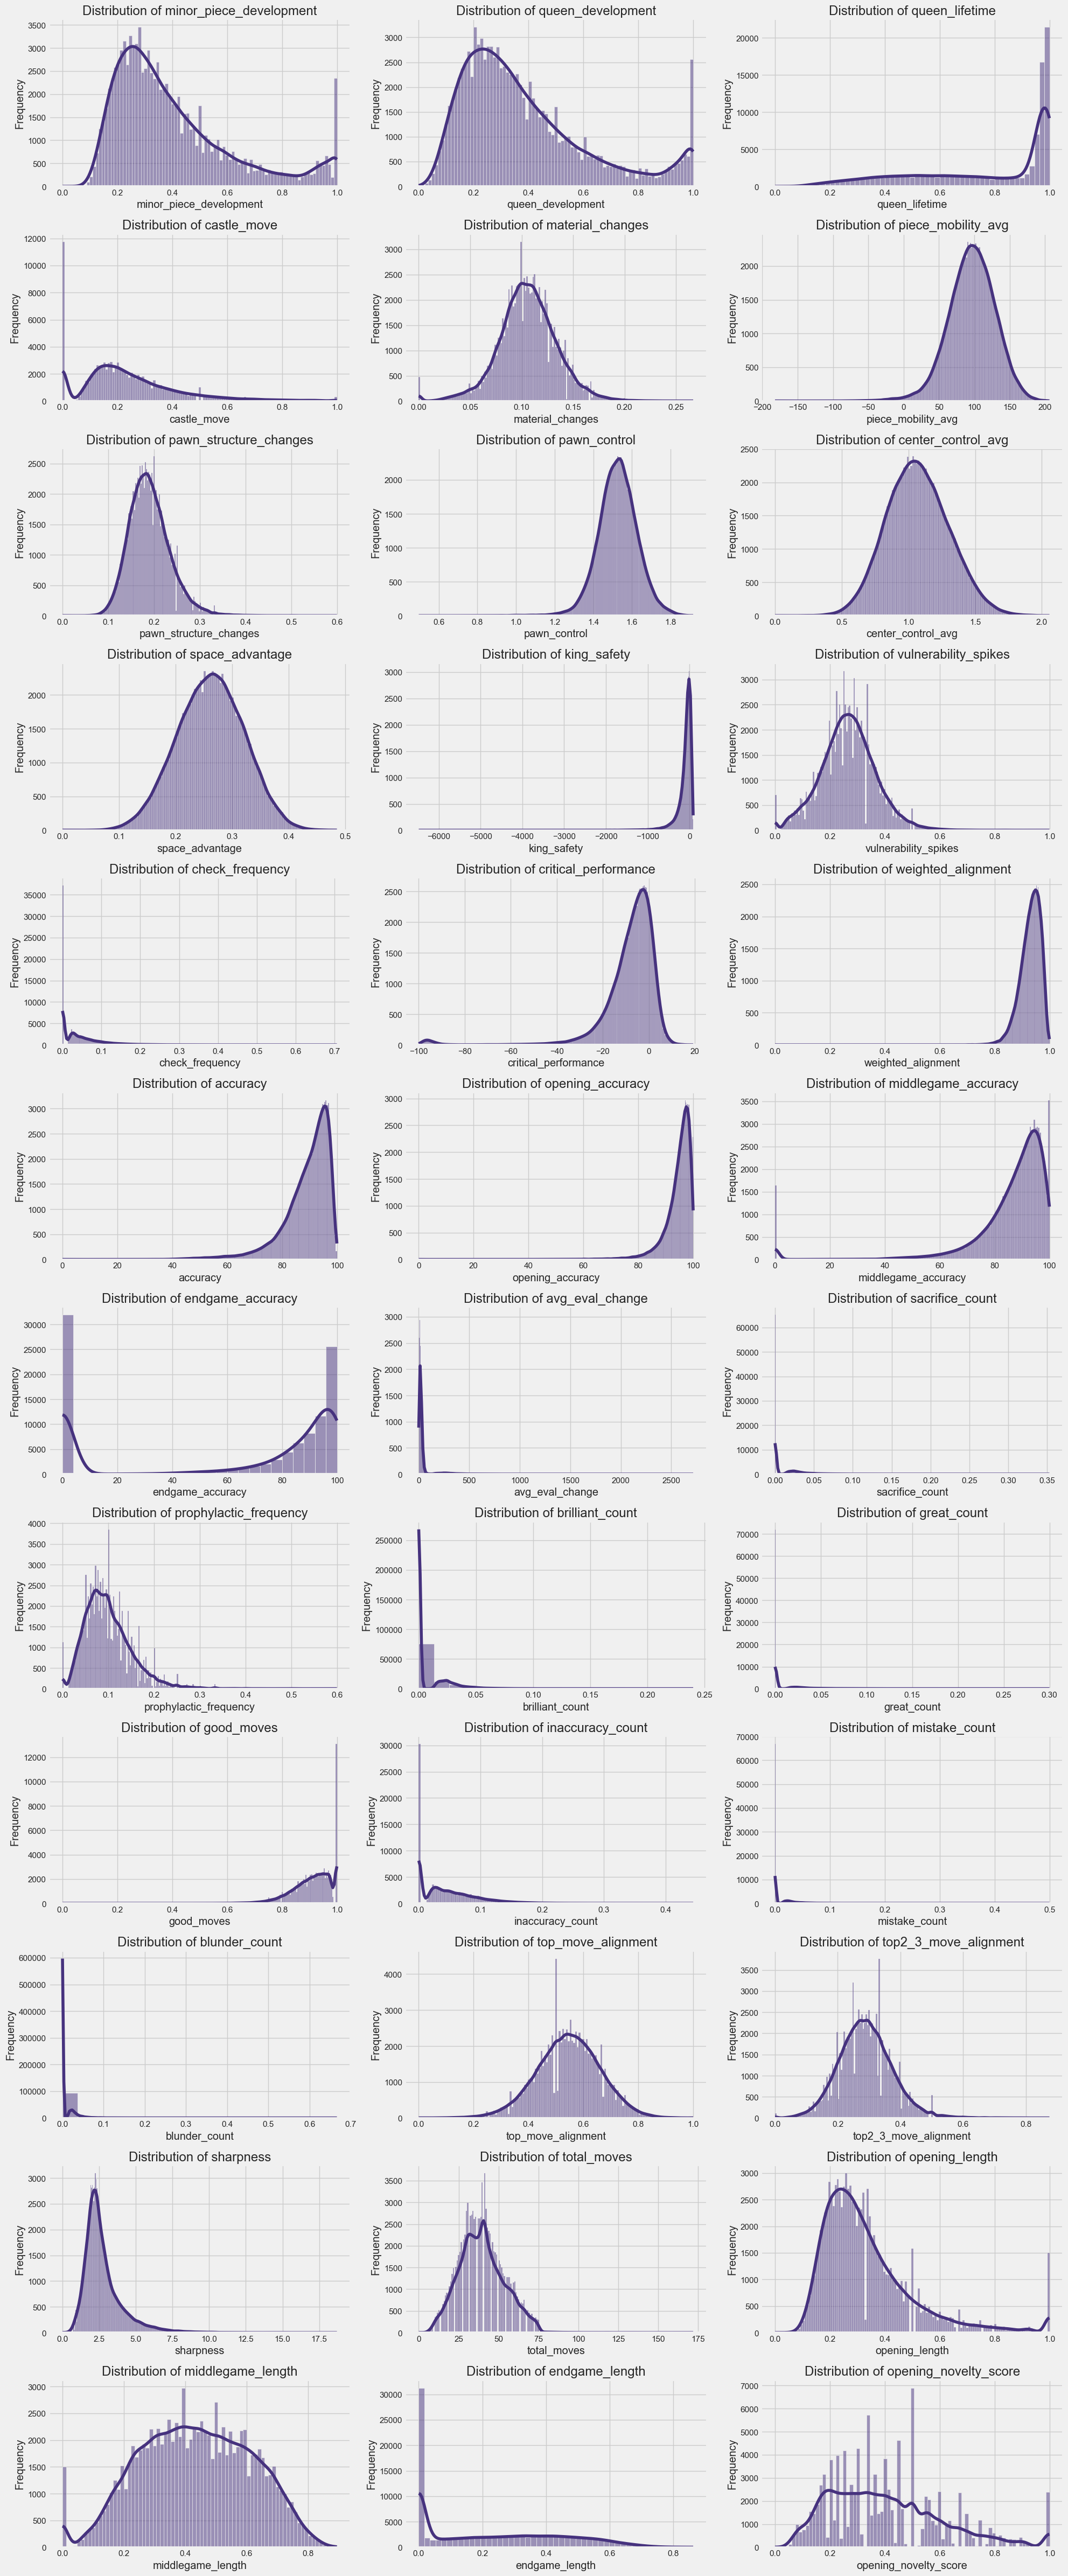

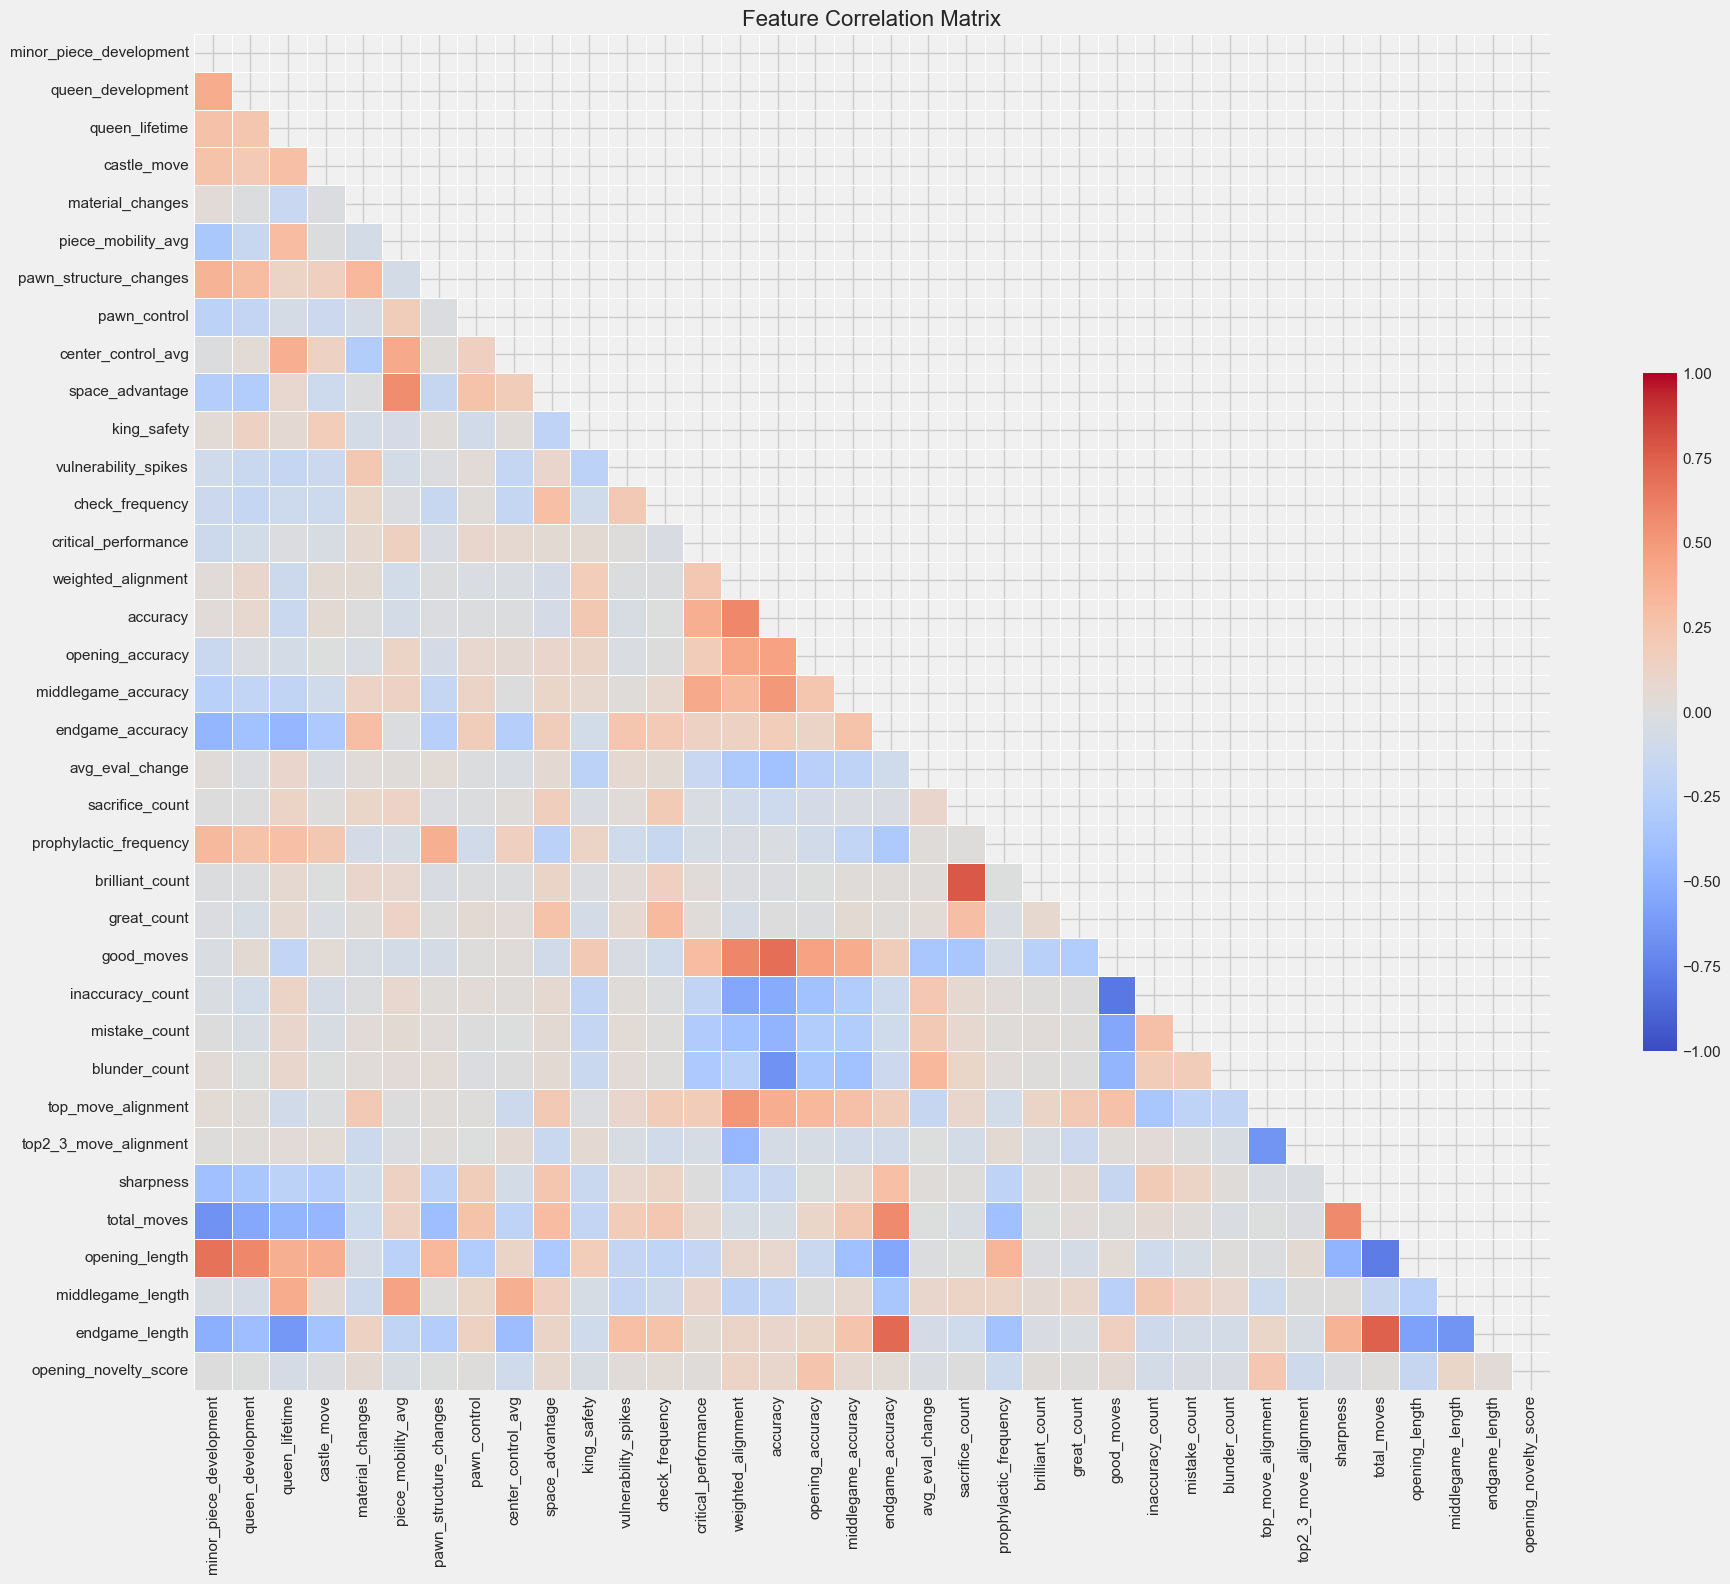


Highly correlated feature pairs (|r| > 0.7):
inaccuracy_count -- good_moves: -0.7938
brilliant_count -- sacrifice_count: 0.7775
opening_length -- total_moves: -0.7757
endgame_length -- total_moves: 0.7423
endgame_length -- endgame_accuracy: 0.7172

Performing Principal Component Analysis...


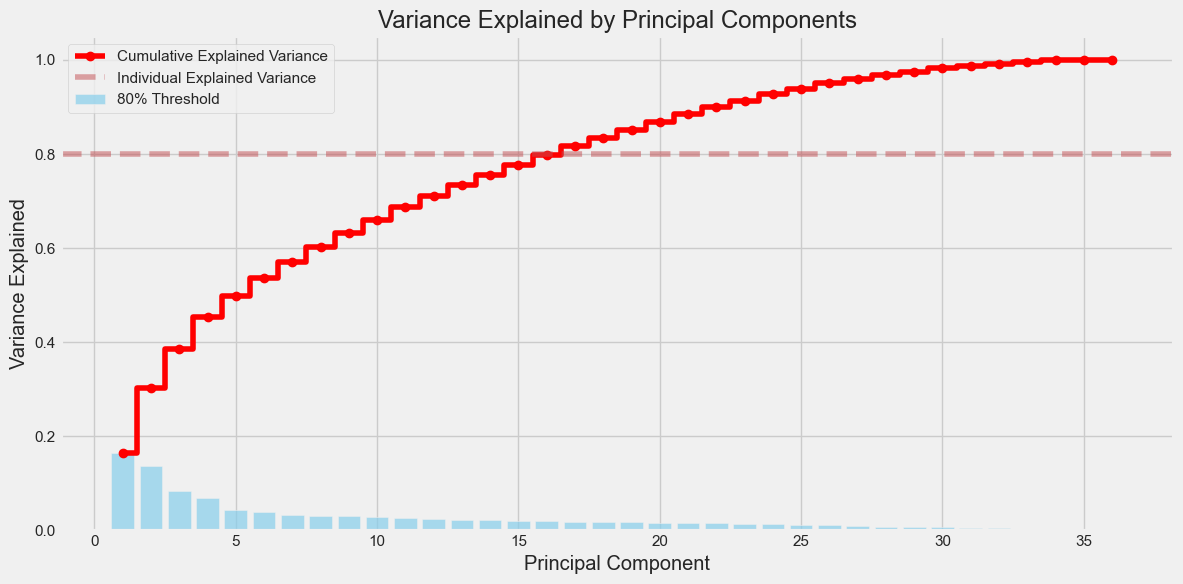


Number of components needed to explain 80% variance: 17


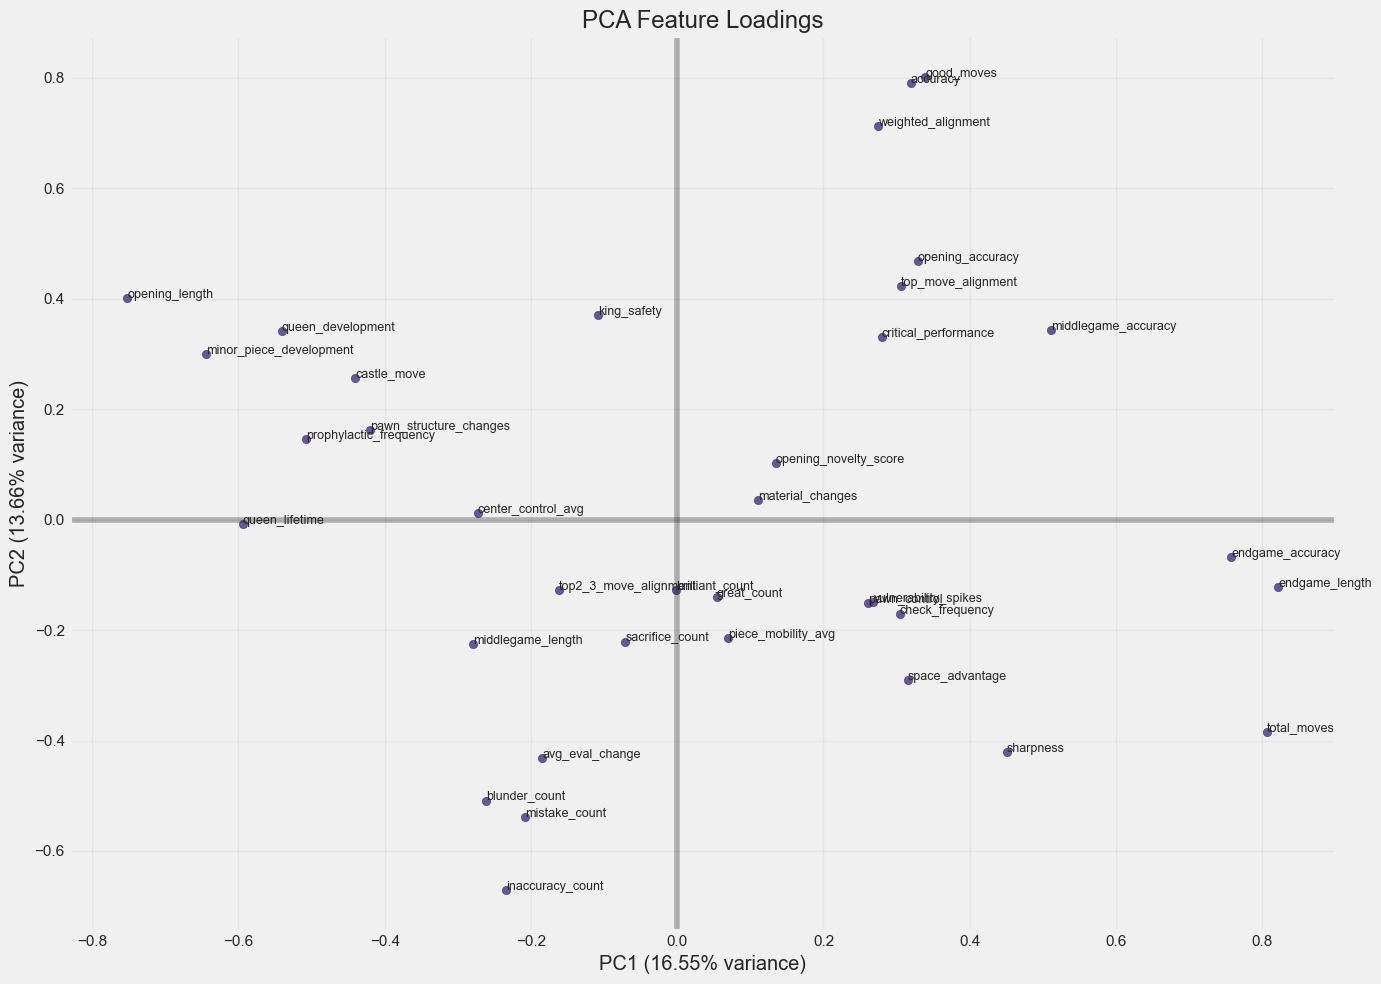

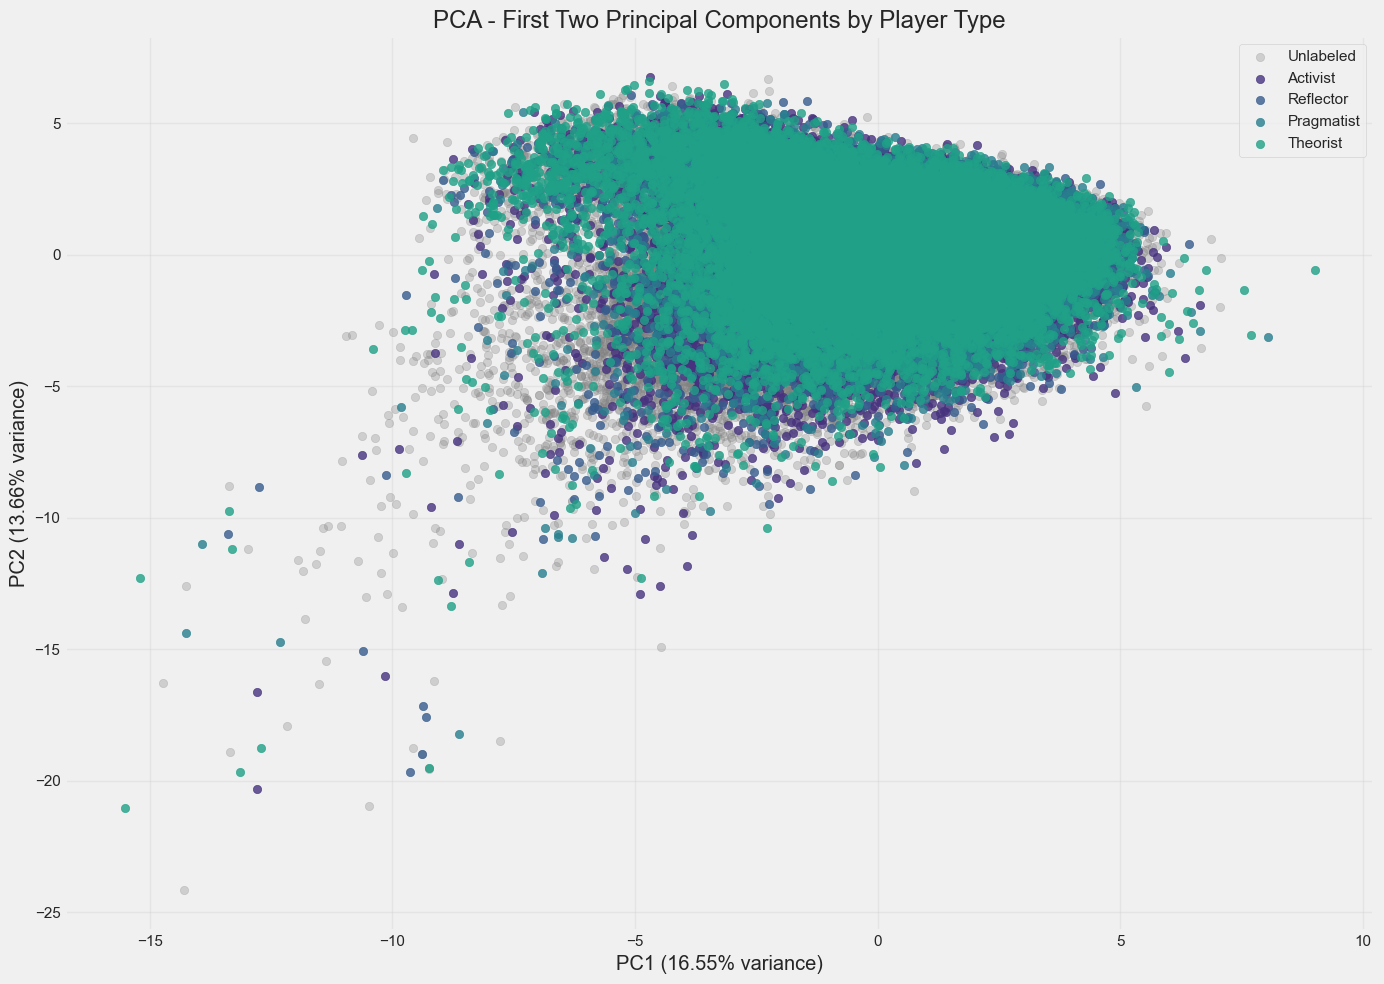


Performing t-SNE visualization...
Starting t-SNE visualization process...
Found 36 numeric features
Sampling 1000 out of 99422 data points
Working with 1000 samples
Found 538 labeled samples
Standardizing features...
Skipping PCA (fewer features than requested components)
Running t-SNE with perplexity=30, max_iter=1000...
t-SNE completed in 2.74 seconds


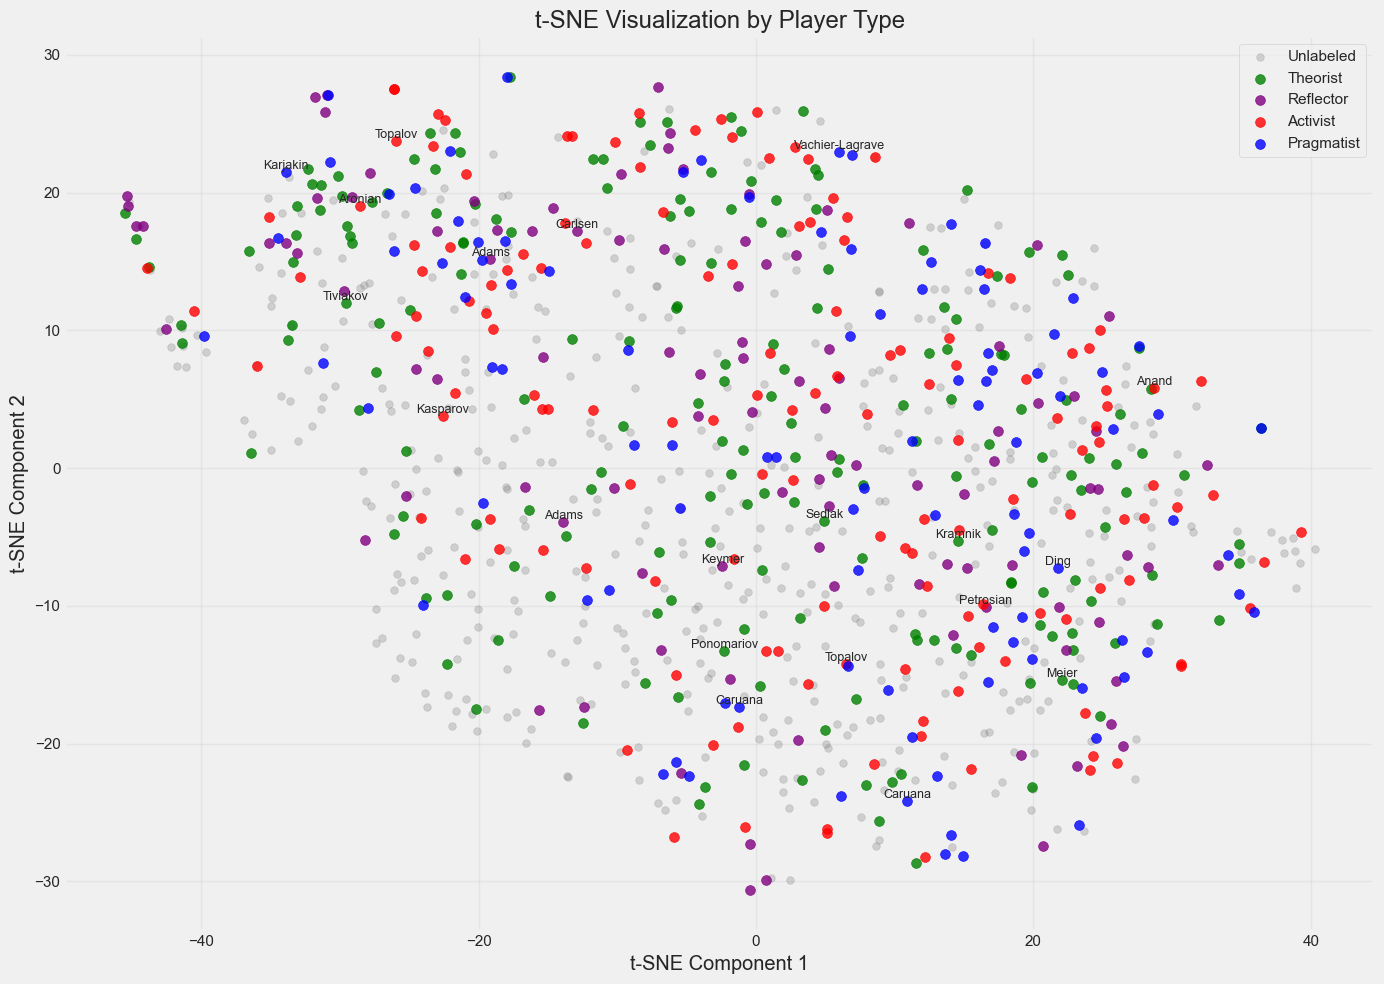


Analyzing features by player type...
Starting feature distribution analysis...
Found 53999 labeled data points

Player type distribution:
  Theorist: 17323 samples
  Activist: 16388 samples
  Pragmatist: 10319 samples
  Reflector: 9969 samples
Using 4 player types with 20+ samples each: ['Theorist', 'Activist', 'Pragmatist', 'Reflector']

Calculating feature significance...
Found 36 features with sufficient data
Processing feature 1/36...
Processing feature 11/36...
Processing feature 21/36...
Processing feature 31/36...

ANOVA calculations completed in 0.5 seconds

Most significant features differentiating player types:
1. space_advantage: p-value = 0.0000 ***
2. opening_novelty_score: p-value = 0.0000 ***
3. top_move_alignment: p-value = 0.0000 ***
4. opening_length: p-value = 0.0000 ***
5. good_moves: p-value = 0.0000 ***
6. material_changes: p-value = 0.0000 ***
7. total_moves: p-value = 0.0000 ***
8. opening_accuracy: p-value = 0.0000 ***
9. top2_3_move_alignment: p-value = 0.000

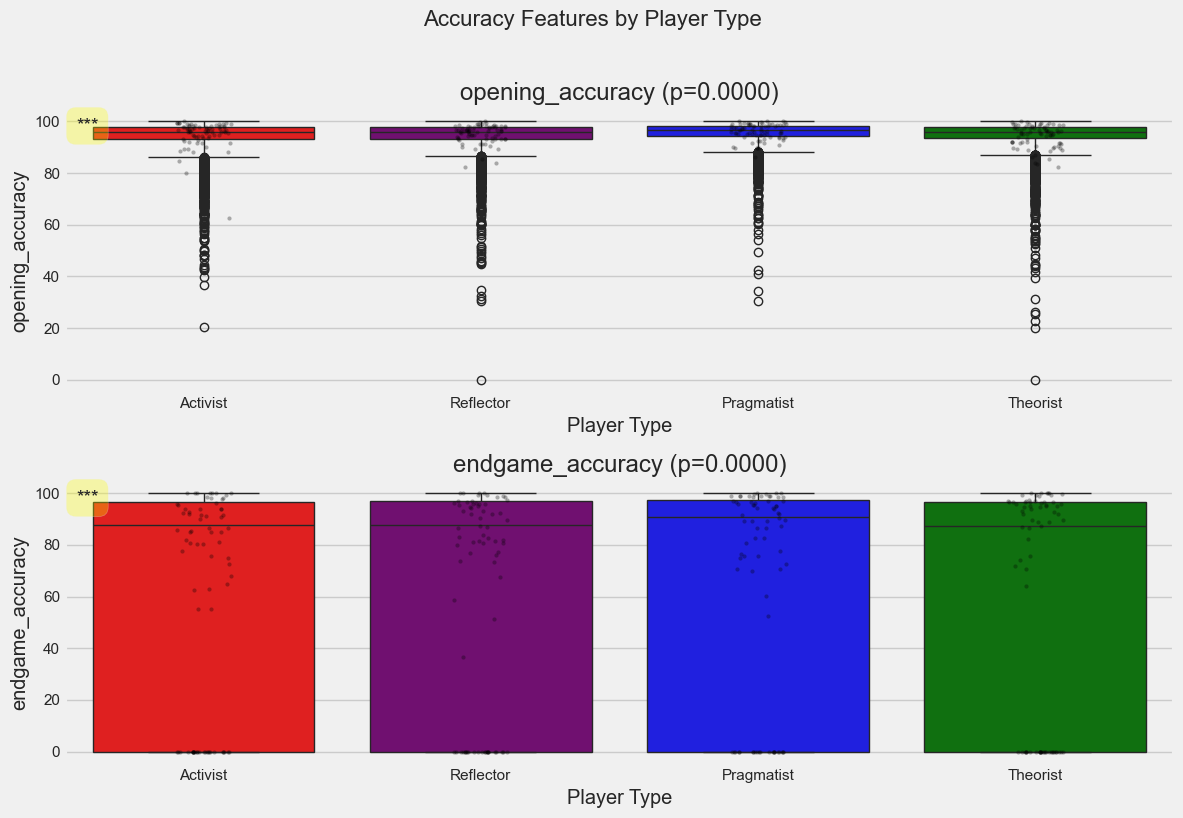

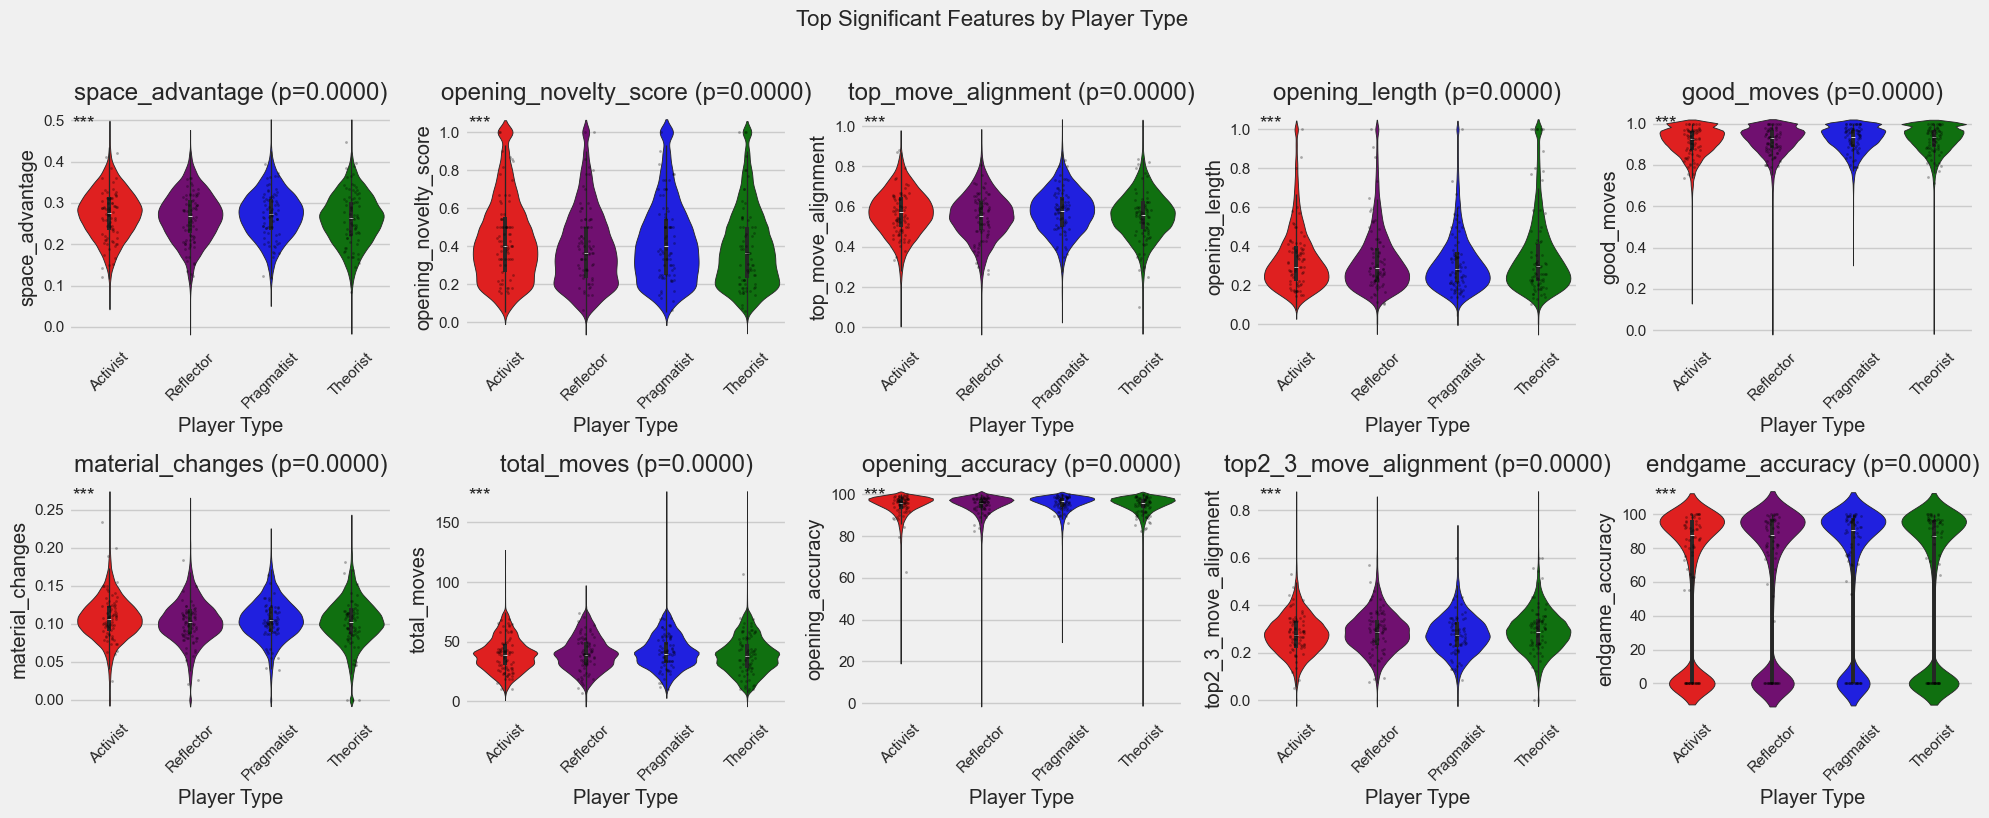


Feature distribution analysis completed in 3.0 seconds
Starting comprehensive player type analysis...

Player type distribution:
  Theorist: 17323 samples
  Activist: 16388 samples
  Pragmatist: 10319 samples
  Reflector: 9969 samples
Analyzing 36 numeric features across 4 player types
Calculating statistics for all features...

COMPREHENSIVE PLAYER TYPE FEATURE COMPARISON

Development & Initiative:
----------------------------------------------------------------------------------------------------
Feature                        p-value    Theorist   Activist   Pragmatist Reflector  Effect    
----------------------------------------------------------------------------------------------------
minor_piece_development ***    0.0000     0.407      0.407      0.383      0.378      7.6%      
castle_move ***                0.0000     0.250      0.241      0.228      0.237      9.7%      
check_frequency ***            0.0000     0.044      0.049      0.048      0.046      12.9%     
queen_

In [4]:
# 3. Exploratory Data Analysis

# 3.1 Distribution Analysis for all numeric features
def plot_feature_distributions():
    """Plot histograms for all numeric features"""
    numeric_features = get_numeric_features()
    
    # Calculate number of rows and columns for subplots
    n_features = len(numeric_features)
    n_cols = 3
    n_rows = (n_features + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows*4))
    axes = axes.flatten()
    
    for i, feature in enumerate(numeric_features):
        if i < len(axes):
            sns.histplot(df[feature].dropna(), kde=True, ax=axes[i])
            axes[i].set_title(f'Distribution of {feature}')
            axes[i].set_xlabel(feature)
            axes[i].set_ylabel('Frequency')
            
            # Add missing value count if any
            na_count = df[feature].isna().sum()
            if na_count > 0:
                axes[i].annotate(f'Missing: {na_count}', xy=(0.7, 0.9), xycoords='axes fraction',
                              fontsize=10, bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.3))
    
    # Hide empty subplots
    for j in range(i+1, len(axes)):
        if j < len(axes):
            axes[j].set_visible(False)
    
    plt.tight_layout()
    plt.show()

def plot_features_by_player_type(df, feature_groups=None, max_features_per_group=3, 
                                max_groups=2, min_samples=10, alpha=0.01,
                                use_swarmplot=False, sample_size=400, dpi=100,
                                skip_plots=False):
    """
    Plot feature distributions grouped by player type - high performance version
    
    Parameters:
    -----------
    df : pandas DataFrame
        The player data
    feature_groups : dict, optional
        Dictionary of feature groups to plot. If None, will use predefined groups.
    max_features_per_group : int, default=3
        Maximum features to plot per group
    max_groups : int, default=2
        Maximum number of feature groups to plot
    min_samples : int, default=10
        Minimum samples required per player type to include feature
    alpha : float, default=0.01
        Significance threshold for ANOVA tests
    use_swarmplot : bool, default=False
        Whether to use swarmplot (slow) or stripplot (fast)
    sample_size : int, default=400
        Maximum number of points to plot per chart (for speed)
    dpi : int, default=100
        Resolution for saved images
    skip_plots : bool, default=False
        If True, only calculates significant features without plotting
    
    Returns:
    --------
    dict : Dictionary of feature p-values
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np
    import pandas as pd
    from scipy import stats
    import time
    
    start_time = time.time()
    print("Starting feature distribution analysis...")
    
    # Count labeled data points
    labeled_count = df['player_type'].notna().sum()
    
    if labeled_count == 0:
        print("No labeled data found. Cannot create player type distributions.")
        return {}
        
    print(f"Found {labeled_count} labeled data points")
    
    # Create a dataframe of only labeled data
    labeled_df = df[df['player_type'].notna()].copy()
    
    # Get player type counts
    type_counts = labeled_df['player_type'].value_counts()
    print("\nPlayer type distribution:")
    for pt, count in type_counts.items():
        print(f"  {pt}: {count} samples")
    
    # Skip types with too few samples
    valid_types = type_counts[type_counts >= min_samples].index.tolist()
    if len(valid_types) < 2:
        print(f"Need at least 2 player types with {min_samples}+ samples each. Analysis stopped.")
        return {}
    
    print(f"Using {len(valid_types)} player types with {min_samples}+ samples each: {valid_types}")
    
    # Filter to keep only valid player types
    labeled_df = labeled_df[labeled_df['player_type'].isin(valid_types)]
    
    # Get numeric features
    metadata_cols = ['player_name', 'player_color', 'opponent_name', 'player_elo', 
                   'player_type', 'game_id', 'result']
    numeric_features = [col for col in df.columns 
                      if col not in metadata_cols and pd.api.types.is_numeric_dtype(df[col])]
    
    # Define feature groups if not provided
    if feature_groups is None:
        feature_groups = {
            'Accuracy Features': [f for f in numeric_features if 'accuracy' in f],
            'Tactical Features': [f for f in numeric_features if any(x in f for x in 
                                 ['sacrifice', 'brilliant', 'blunder', 'mistake', 'sharpness'])],
            'Positional Features': [f for f in numeric_features if any(x in f for x in 
                                  ['prophylactic', 'mobility', 'center_control', 'king_safety'])],
            'Strategic Features': [f for f in numeric_features if any(x in f for x in
                                 ['space_advantage', 'pawn_control', 'material_balance'])]
        }
    
    # Limit to max_groups
    feature_groups = dict(list(feature_groups.items())[:max_groups])
    
    # Find significant features
    print("\nCalculating feature significance...")
    start_calc_time = time.time()
    all_p_values = {}
    
    # Calculate data availability for each feature
    feature_availability = {}
    for feature in numeric_features:
        # Count non-missing values per player type
        availability = labeled_df.groupby('player_type')[feature].count()
        # Only include feature if all player types have sufficient samples
        if (availability >= min_samples).all():
            feature_availability[feature] = availability.min()
    
    print(f"Found {len(feature_availability)} features with sufficient data")
    
    # Calculate ANOVA p-values for features with sufficient data
    total_features = len(feature_availability)
    for i, (feature, min_avail) in enumerate(feature_availability.items()):
        # Progress reporting for long calculations
        if i % 10 == 0:
            print(f"Processing feature {i+1}/{total_features}...")
            
        # Create clean data for this feature
        feature_data = labeled_df[['player_type', feature]].dropna()
        
        # Create groups for ANOVA
        groups = [feature_data[feature_data['player_type'] == pt][feature].values 
                 for pt in feature_data['player_type'].unique()]
        
        try:
            f_val, p_val = stats.f_oneway(*groups)
            all_p_values[feature] = p_val
        except:
            # Skip if ANOVA fails
            continue
    
    # Sort features by p-value
    sorted_features = sorted(all_p_values.items(), key=lambda x: x[1])
    
    # Print most significant features
    print(f"\nANOVA calculations completed in {time.time() - start_calc_time:.1f} seconds")
    print("\nMost significant features differentiating player types:")
    for i, (feature, p_val) in enumerate(sorted_features[:10]):
        significant = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else ""
        print(f"{i+1}. {feature}: p-value = {p_val:.4f} {significant}")
    
    # Skip plotting if requested
    if skip_plots:
        print("Skipping plots as requested.")
        print(f"Analysis completed in {time.time() - start_time:.1f} seconds")
        return dict(sorted_features)
    
    # Plot feature distributions for each group
    print("\nCreating distribution plots...")
    for group_name, features in feature_groups.items():
        # Filter to features that exist in the dataset and have p-values
        valid_features = [f for f in features if f in all_p_values]
        
        if not valid_features:
            print(f"No valid features in group: {group_name}")
            continue
            
        # Sort by significance and take top N
        sorted_features_group = sorted([(f, all_p_values[f]) for f in valid_features], 
                                key=lambda x: x[1])
        top_features = [f[0] for f in sorted_features_group[:max_features_per_group]]
        
        print(f"\nPlotting {len(top_features)} features from group: {group_name}")
        
        # Create the plot
        fig, axes = plt.subplots(len(top_features), 1, figsize=(12, 4*len(top_features)))
        if len(top_features) == 1:
            axes = [axes]
        
        plt.suptitle(f"{group_name} by Player Type", fontsize=16, y=1.02)
        
        # Define colors for player types
        type_colors = {
            'Activist': 'red',
            'Pragmatist': 'blue',
            'Theorist': 'green',
            'Reflector': 'purple'
        }
        
        # Create a custom palette based on player types
        palette = {pt: type_colors.get(pt, 'orange') for pt in valid_types}
        
        for i, feature in enumerate(top_features):
            # Get clean data (drop NaN for this visualization)
            feature_data = labeled_df[['player_type', feature]].dropna()
            
            # Box plot with custom palette
            sns.boxplot(x='player_type', y=feature, data=feature_data, 
                      palette=palette, ax=axes[i])
            
            # PERFORMANCE OPTIMIZATION: Sample data for individual points
            if use_swarmplot:
                # Use swarmplot (slow but accurate positioning)
                if len(feature_data) > sample_size:
                    # If we have a lot of data, sample it down
                    plot_sample = feature_data.groupby('player_type').apply(
                        lambda x: x.sample(min(len(x), sample_size//len(feature_data['player_type'].unique())), 
                                          random_state=42)
                    ).reset_index(drop=True)
                else:
                    plot_sample = feature_data
                
                sns.swarmplot(x='player_type', y=feature, data=plot_sample, 
                            color='black', alpha=0.3, size=3, ax=axes[i])
            else:
                # Use stripplot (much faster, with jitter)
                if len(feature_data) > sample_size:
                    # If we have a lot of data, sample it down
                    plot_sample = feature_data.groupby('player_type').apply(
                        lambda x: x.sample(min(len(x), sample_size//len(feature_data['player_type'].unique())), 
                                          random_state=42)
                    ).reset_index(drop=True)
                else:
                    plot_sample = feature_data
                
                sns.stripplot(x='player_type', y=feature, data=plot_sample, 
                            color='black', alpha=0.3, size=3, jitter=True, ax=axes[i])
            
            axes[i].set_title(f'{feature} (p={all_p_values[feature]:.4f})')
            axes[i].set_xlabel('Player Type')
            axes[i].set_ylabel(feature)
            
            # Add significance markers
            p_val = all_p_values[feature]
            if p_val < alpha:
                sig_marker = '***' if p_val < 0.001 else '**' if p_val < 0.01 else '*'
                axes[i].annotate(sig_marker, xy=(0.01, 0.97), xycoords='axes fraction',
                              fontsize=14, ha='left', va='top',
                              bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.3))
        
        plt.tight_layout()
        plt.savefig(f'feature_distribution_{group_name.replace(" ", "_")}.png', dpi=dpi)
        plt.show()
    
    # Create a single plot of the top significant features overall
    top_significant = [f for f, p in sorted_features[:min(10, len(sorted_features))]]
    
    if top_significant:
        # Use a 2x5 grid or smaller depending on data
        rows = min(2, (len(top_significant) + 4) // 5)  # Ceiling division, max 2 rows
        cols = min(5, len(top_significant))
        
        # Don't create more subplots than features
        if rows * cols > len(top_significant):
            if len(top_significant) <= 5:
                rows = 1
                cols = len(top_significant)
            else:
                rows = 2
                cols = (len(top_significant) + 1) // 2  # Ceiling division
        
        fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4*rows))
        if rows == 1 and cols == 1:
            axes = np.array([axes])  # Make sure it's an array
        axes = axes.flatten() if hasattr(axes, 'flatten') else [axes]
        
        plt.suptitle('Top Significant Features by Player Type', fontsize=16, y=1.02)
        
        for i, feature in enumerate(top_significant):
            if i < len(axes):
                # Get clean data for this feature
                feature_data = labeled_df[['player_type', feature]].dropna()
                
                if not feature_data.empty:
                    # Create violin plot
                    sns.violinplot(x='player_type', y=feature, data=feature_data, 
                                 palette=palette, ax=axes[i])
                    
                    # PERFORMANCE OPTIMIZATION: Sample data for individual points
                    if len(feature_data) > sample_size:
                        plot_sample = feature_data.groupby('player_type').apply(
                            lambda x: x.sample(min(len(x), sample_size//len(feature_data['player_type'].unique())), 
                                              random_state=42)
                        ).reset_index(drop=True)
                    else:
                        plot_sample = feature_data
                    
                    # Add individual data points as stripplot (faster than swarmplot)
                    sns.stripplot(x='player_type', y=feature, data=plot_sample,
                                color='black', alpha=0.3, size=2, ax=axes[i], jitter=True)
                    
                    axes[i].set_title(f'{feature} (p={all_p_values[feature]:.4f})')
                    axes[i].set_xlabel('Player Type')
                    axes[i].set_ylabel(feature)
                    plt.setp(axes[i].xaxis.get_majorticklabels(), rotation=45)
                    
                    # Add significance markers
                    p_val = all_p_values[feature]
                    if p_val < alpha:
                        sig_marker = '***' if p_val < 0.001 else '**' if p_val < 0.01 else '*'
                        axes[i].annotate(sig_marker, xy=(0.01,.97), xycoords='axes fraction',
                                      fontsize=14, ha='left', va='top')
                else:
                    axes[i].text(0.5, 0.5, f'No data available for {feature}', 
                               ha='center', va='center', fontsize=12)
        
        # Hide any unused subplots
        for j in range(i+1, len(axes)):
            axes[j].set_visible(False)
        
        plt.tight_layout()
        plt.savefig('top_significant_features.png', dpi=dpi)
        plt.show()
    
    print(f"\nFeature distribution analysis completed in {time.time() - start_time:.1f} seconds")
    
    # Return the p-values dictionary for potential further analysis
    return dict(sorted_features)

def find_most_significant_features(df, n=10, min_samples=5):
    """
    Find the most significant features that differentiate player types
    
    Parameters:
    -----------
    df : pandas DataFrame
        The player data
    n : int, default=10
        Number of features to return
    min_samples : int, default=5
        Minimum samples required per player type
    
    Returns:
    --------
    list : Top significant features
    """
    import pandas as pd
    import numpy as np
    from scipy import stats
    import time
    
    start_time = time.time()
    print(f"Finding the {n} most significant features...")
    
    # Check for labeled data
    labeled_df = df[df['player_type'].notna()].copy()
    if len(labeled_df) == 0:
        print("No labeled data found.")
        return []
    
    # Get player type counts
    type_counts = labeled_df['player_type'].value_counts()
    valid_types = type_counts[type_counts >= min_samples].index.tolist()
    
    if len(valid_types) < 2:
        print(f"Need at least 2 player types with {min_samples}+ samples each.")
        return []
    
    # Filter to keep only valid player types
    labeled_df = labeled_df[labeled_df['player_type'].isin(valid_types)]
    
    # Get numeric features
    metadata_cols = ['player_name', 'player_color', 'opponent_name', 'player_elo', 
                   'player_type', 'game_id', 'result']
    numeric_features = [col for col in df.columns if col not in metadata_cols]
    
    # Calculate p-value for each feature using ANOVA
    significant_features = []
    p_values = []
    
    for feature in numeric_features:
        # Skip if feature has too many missing values
        if labeled_df[feature].isna().sum() > len(labeled_df) * 0.25:
            continue
            
        # Create clean data for this feature
        feature_data = labeled_df[['player_type', feature]].dropna()
        
        # Skip if any player type has too few samples
        type_samples = feature_data.groupby('player_type').size()
        if (type_samples < min_samples).any():
            continue
        
        # Create groups for ANOVA
        groups = [feature_data[feature_data['player_type'] == pt][feature].values 
                 for pt in feature_data['player_type'].unique()]
        
        try:
            f_val, p_val = stats.f_oneway(*groups)
            significant_features.append(feature)
            p_values.append(p_val)
        except:
            # Skip if ANOVA fails
            continue
    
    # Select top N significant features
    if significant_features:
        # Sort by p-value (ascending)
        sorted_indices = np.argsort(p_values)
        top_features = [significant_features[i] for i in sorted_indices[:n]]
        
        print("\nMost significant features differentiating player types:")
        for i, (feature, p_val) in enumerate(zip([significant_features[i] for i in sorted_indices[:n]], 
                                              [p_values[i] for i in sorted_indices[:n]])):
            significant = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else ""
            print(f"{i+1}. {feature}: p-value = {p_val:.4f} {significant}")
        
        print(f"Analysis completed in {time.time() - start_time:.2f} seconds")
        return top_features
    
    print("No significant features found.")
    return []


# 3.3 Correlation Analysis
def plot_correlation_matrix():
    """Plot correlation matrix for all numeric features"""
    numeric_features = get_numeric_features()
    
    # Get clean data with imputed values
    clean_data = get_clean_data(features=numeric_features)
    
    # Calculate correlation matrix
    corr_matrix = clean_data.corr()
    
    # Create a mask for the upper triangle
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    
    # Set up the matplotlib figure
    plt.figure(figsize=(20, 16))
    
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', vmax=1, vmin=-1, center=0,
                square=True, linewidths=.5, annot=False, fmt='.2f', cbar_kws={"shrink": .5})
    
    plt.title('Feature Correlation Matrix', fontsize=16)
    plt.tight_layout()
    plt.show()
    
    # List of highly correlated feature pairs (|r| > 0.7)
    high_corr_pairs = []
    
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > 0.7:
                high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))
    
    if high_corr_pairs:
        print("\nHighly correlated feature pairs (|r| > 0.7):")
        for feat1, feat2, corr in sorted(high_corr_pairs, key=lambda x: abs(x[2]), reverse=True):
            print(f"{feat1} -- {feat2}: {corr:.4f}")

# 3.4 Principal Component Analysis
def perform_pca():
    """Perform PCA on the features and visualize results"""
    # Get numeric features
    numeric_features = get_numeric_features()
    
    # Get clean data with imputed values
    clean_data = get_clean_data(features=numeric_features)
    
    # Standardize the data
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(clean_data)
    
    # Perform PCA
    pca = PCA()
    pca_result = pca.fit_transform(scaled_features)
    
    # Create a DataFrame for the PCA results
    pca_df = pd.DataFrame(data=pca_result[:, :2], columns=['PC1', 'PC2'])
    
    # Add player type and name information
    pca_df['player_name'] = df['player_name']
    pca_df['player_type'] = df['player_type']
    pca_df['player_color'] = df['player_color']
    
    # Calculate variance explained
    explained_variance = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance)
    
    # Plot variance explained
    plt.figure(figsize=(12, 6))
    plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.7, color='skyblue')
    plt.step(range(1, len(cumulative_variance) + 1), cumulative_variance, where='mid', color='red', marker='o')
    plt.axhline(y=0.8, color='r', linestyle='--', alpha=0.5)
    plt.xlabel('Principal Component')
    plt.ylabel('Variance Explained')
    plt.title('Variance Explained by Principal Components')
    plt.legend(['Cumulative Explained Variance', 'Individual Explained Variance', '80% Threshold'])
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # Determine number of components needed to explain 80% variance
    n_components = np.argmax(cumulative_variance >= 0.8) + 1
    print(f"\nNumber of components needed to explain 80% variance: {n_components}")
    
    # Plot feature loadings for the first two PCs
    loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
    
    plt.figure(figsize=(14, 10))
    plt.scatter(loadings[:, 0], loadings[:, 1], alpha=0.8)
    
    # Add feature names as annotations
    for i, feature in enumerate(numeric_features):
        plt.annotate(feature, (loadings[i, 0], loadings[i, 1]), fontsize=9)
    
    plt.xlabel(f"PC1 ({explained_variance[0]:.2%} variance)")
    plt.ylabel(f"PC2 ({explained_variance[1]:.2%} variance)")
    plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    plt.axvline(x=0, color='k', linestyle='-', alpha=0.3)
    plt.grid(True, alpha=0.3)
    plt.title('PCA Feature Loadings')
    plt.tight_layout()
    plt.show()
    
    # Plot PCA colored by player type
    if labeled_count > 0:
        plt.figure(figsize=(14, 10))
        
        # Plot unlabeled data first in grey
        unlabeled = pca_df[pca_df['player_type'].isna()]
        if not unlabeled.empty:
            plt.scatter(unlabeled['PC1'], unlabeled['PC2'], alpha=0.3, c='grey', label='Unlabeled')
        
        # Plot labeled data colored by player type
        for pt in df['player_type'].dropna().unique():
            subset = pca_df[pca_df['player_type'] == pt]
            plt.scatter(subset['PC1'], subset['PC2'], alpha=0.8, label=pt)
        
        plt.xlabel(f"PC1 ({explained_variance[0]:.2%} variance)")
        plt.ylabel(f"PC2 ({explained_variance[1]:.2%} variance)")
        plt.title('PCA - First Two Principal Components by Player Type')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    
    # Return PCA results and components for later use
    return pca, pca_result, numeric_features

# 3.5 t-SNE Visualization
def plot_tsne(df, max_samples=1000, pca_components=50, perplexity=30, n_iter=1000):
    """
    Perform t-SNE on the features and visualize results with optimizations
    for speed and efficiency.
    
    Parameters:
    -----------
    df : pandas DataFrame
        The player data
    max_samples : int, default=1000
        Maximum number of samples to use for t-SNE (random sample if more)
    pca_components : int, default=50
        Number of PCA components to use before t-SNE (dimensionality reduction)
    perplexity : int, default=30
        t-SNE perplexity parameter
    n_iter : int, default=1000
        Maximum number of iterations for t-SNE
    """
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    from sklearn.preprocessing import StandardScaler
    from sklearn.decomposition import PCA
    from sklearn.manifold import TSNE
    import time
    try:
        import plotly.express as px
    except ImportError:
        print("Plotly not available, skipping interactive plot")
    
    print("Starting t-SNE visualization process...")
    start_time = time.time()
    
    # Get numeric features (excluding metadata columns)
    metadata_cols = ['player_name', 'player_color', 'opponent_name', 'player_elo', 
                   'player_type', 'game_id', 'result']
    numeric_features = [col for col in df.columns if col not in metadata_cols and pd.api.types.is_numeric_dtype(df[col])]
    
    print(f"Found {len(numeric_features)} numeric features")
    
    # Sample the data if it's too large
    if len(df) > max_samples:
        print(f"Sampling {max_samples} out of {len(df)} data points")
        df_sample = df.sample(max_samples, random_state=42)
    else:
        df_sample = df.copy()
    
    print(f"Working with {len(df_sample)} samples")
    
    # Count labeled samples
    labeled_count = df_sample['player_type'].notna().sum()
    print(f"Found {labeled_count} labeled samples")
    
    # Get clean data with imputed values
    # First check if there are missing values
    missing_data = df_sample[numeric_features].isna().sum().sum()
    if missing_data > 0:
        print(f"Imputing {missing_data} missing values")
        # Simple imputation with median
        from sklearn.impute import SimpleImputer
        imputer = SimpleImputer(strategy='median')
        clean_data = pd.DataFrame(
            imputer.fit_transform(df_sample[numeric_features]),
            columns=numeric_features
        )
    else:
        clean_data = df_sample[numeric_features].copy()
    
    # Standardize the data
    print("Standardizing features...")
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(clean_data)
    
    # Use PCA for initial dimensionality reduction
    if len(numeric_features) > pca_components:
        print(f"Reducing dimensions from {len(numeric_features)} to {pca_components} with PCA")
        pca = PCA(n_components=pca_components)
        pca_result = pca.fit_transform(scaled_features)
        tsne_input = pca_result
        variance_explained = np.sum(pca.explained_variance_ratio_)
        print(f"Variance explained by {pca_components} components: {variance_explained:.2%}")
    else:
        print("Skipping PCA (fewer features than requested components)")
        tsne_input = scaled_features
    
    # Adjust perplexity if needed
    actual_perplexity = min(perplexity, len(df_sample) - 1)
    if actual_perplexity != perplexity:
        print(f"Adjusting perplexity from {perplexity} to {actual_perplexity} due to sample size")
    
    # Perform t-SNE with early stopping
    print(f"Running t-SNE with perplexity={actual_perplexity}, max_iter={n_iter}...")
    tsne = TSNE(
        n_components=2,
        perplexity=actual_perplexity,
        n_iter=n_iter,
        n_iter_without_progress=100,  # Stop early if no progress
        random_state=42
    )
    
    tsne_result = tsne.fit_transform(tsne_input)
    print(f"t-SNE completed in {time.time() - start_time:.2f} seconds")
    
    # Create a DataFrame for the t-SNE results
    tsne_df = pd.DataFrame(data=tsne_result, columns=['TSNE1', 'TSNE2'])
    tsne_df['player_name'] = df_sample['player_name'].values
    tsne_df['player_type'] = df_sample['player_type'].values
    tsne_df['player_color'] = df_sample['player_color'].values
    
    # Plot t-SNE colored by player type
    if labeled_count > 0:
        plt.figure(figsize=(14, 10))
        
        # Plot unlabeled data first in grey
        unlabeled = tsne_df[tsne_df['player_type'].isna()]
        if not unlabeled.empty:
            plt.scatter(unlabeled['TSNE1'], unlabeled['TSNE2'], 
                       alpha=0.3, c='grey', label='Unlabeled', s=30)
        
        # Define colors for player types
        type_colors = {
            'Activist': 'red',
            'Pragmatist': 'blue',
            'Theorist': 'green',
            'Reflector': 'purple'
        }
        
        # Plot labeled data colored by player type
        for pt in df_sample['player_type'].dropna().unique():
            subset = tsne_df[tsne_df['player_type'] == pt]
            plt.scatter(
                subset['TSNE1'], 
                subset['TSNE2'], 
                alpha=0.8, 
                label=pt,
                c=type_colors.get(pt, 'orange'),
                s=50
            )
            
            # Add labels for famous players (optional)
            famous_players = subset.head(5)  # Label first 5 of each type
            for _, player in famous_players.iterrows():
                plt.text(
                    player['TSNE1'], 
                    player['TSNE2'], 
                    player['player_name'].split(',')[0],  # First part of name
                    fontsize=9,
                    ha='center',
                    va='bottom'
                )
        
        plt.xlabel('t-SNE Component 1')
        plt.ylabel('t-SNE Component 2')
        plt.title('t-SNE Visualization by Player Type')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig('tsne_player_types.png', dpi=300)
        plt.show()
    
        # Create interactive Plotly version (if available)
        try:
            fig = px.scatter(
                tsne_df,
                x='TSNE1',
                y='TSNE2',
                color='player_type',
                hover_name='player_name',
                color_discrete_map=type_colors,
                title='t-SNE Visualization of Chess Player Types',
                opacity=0.8
            )
            fig.update_layout(width=1000, height=800)
            fig.show()
        except:
            print("Skipping interactive plot due to error")
    
    return tsne_result

def comprehensive_player_type_analysis(df, exclude_cols=None, min_samples=20):
    """
    Generate a comprehensive text comparison of all features across player types
    
    Parameters:
    -----------
    df : pandas DataFrame
        The player data containing features and player_type column
    exclude_cols : list, optional
        List of columns to exclude from analysis
    min_samples : int, default=20
        Minimum samples required per player type and feature
    """
    import pandas as pd
    import numpy as np
    from scipy import stats
    import time
    
    start_time = time.time()
    print("Starting comprehensive player type analysis...")
    
    # Define metadata columns to exclude
    if exclude_cols is None:
        exclude_cols = ['player_name', 'player_color', 'opponent_name', 'player_elo', 
                      'game_id', 'result']
    
    # Ensure player_type is not in exclude_cols
    if 'player_type' in exclude_cols:
        exclude_cols.remove('player_type')
    
    # Get labeled data only
    labeled_df = df[df['player_type'].notna()].copy()
    if len(labeled_df) == 0:
        print("No labeled data found")
        return
    
    # Get player types and sample counts
    player_types = labeled_df['player_type'].unique()
    type_counts = labeled_df['player_type'].value_counts()
    
    print("\nPlayer type distribution:")
    for pt, count in type_counts.items():
        print(f"  {pt}: {count} samples")
    
    # Filter to player types with sufficient samples
    valid_types = type_counts[type_counts >= min_samples].index.tolist()
    if len(valid_types) < 2:
        print(f"Need at least 2 player types with {min_samples}+ samples each")
        return
    
    labeled_df = labeled_df[labeled_df['player_type'].isin(valid_types)]
    player_types = valid_types
    
    # Get numeric features
    numeric_features = [col for col in df.columns 
                      if col not in exclude_cols 
                      and col != 'player_type'
                      and pd.api.types.is_numeric_dtype(df[col])]
    
    print(f"Analyzing {len(numeric_features)} numeric features across {len(player_types)} player types")
    
    # Define feature categories
    feature_categories = {
        'Accuracy & Precision': ['accuracy', 'opening_accuracy', 'middlegame_accuracy', 'endgame_accuracy', 
                               'top_move_alignment', 'top2_3_move_alignment', 'good_moves'],
        'Tactical Elements': ['sacrifice', 'brilliant', 'great', 'mistake', 'blunder', 'inaccuracy', 'sharpness'],
        'Strategic Elements': ['space_advantage', 'center_control', 'piece_mobility', 'king_safety',
                              'prophylactic', 'pawn_control', 'pawn_structure'],
        'Material Handling': ['material_', 'piece_exchange', 'capture_frequency'],
        'Game Phase Length': ['total_moves', 'opening_length', 'middlegame_length', 'endgame_length'],
        'Development & Initiative': ['minor_piece_development', 'queen_development', 'castle_move', 'check_frequency'],
        'Game Dynamics': ['opening_novelty', 'eval_', 'forced_complexity', 'speculative']
    }
    
    # Organize features by category
    categorized_features = {}
    uncategorized_features = []
    
    for feature in numeric_features:
        categorized = False
        for category, keywords in feature_categories.items():
            if any(keyword in feature for keyword in keywords):
                if category not in categorized_features:
                    categorized_features[category] = []
                categorized_features[category].append(feature)
                categorized = True
                break
        
        if not categorized:
            uncategorized_features.append(feature)
    
    if uncategorized_features:
        categorized_features['Other Metrics'] = uncategorized_features
    
    # Calculate statistics for all features
    feature_stats = {}
    all_p_values = {}
    
    print("Calculating statistics for all features...")
    
    for feature in numeric_features:
        # Calculate availability per player type
        availability = labeled_df.groupby('player_type')[feature].count()
        
        # Skip if any player type has insufficient samples
        if (availability < min_samples).any():
            continue
        
        # Get clean data for ANOVA
        feature_data = labeled_df[['player_type', feature]].dropna()
        
        # Calculate means for each player type
        means = {}
        stds = {}
        for pt in player_types:
            type_data = feature_data[feature_data['player_type'] == pt][feature]
            means[pt] = type_data.mean() if len(type_data) > 0 else np.nan
            stds[pt] = type_data.std() if len(type_data) > 0 else np.nan
        
        # Store statistics
        feature_stats[feature] = {
            'means': means,
            'stds': stds,
            'overall_mean': feature_data[feature].mean()
        }
        
        # Calculate p-value with ANOVA
        try:
            groups = [feature_data[feature_data['player_type'] == pt][feature].values 
                     for pt in player_types]
            f_val, p_val = stats.f_oneway(*groups)
            all_p_values[feature] = p_val
        except:
            # Skip if ANOVA fails
            continue
    
    # Sort features by p-value
    sorted_features = sorted(all_p_values.items(), key=lambda x: x[1])
    
    # Print header
    print("\n" + "="*100)
    print("COMPREHENSIVE PLAYER TYPE FEATURE COMPARISON")
    print("="*100)
    
    # Print analysis by category
    for category, features in categorized_features.items():
        # Filter to features with statistics
        category_features = [f for f in features if f in feature_stats]
        
        if not category_features:
            continue
        
        print(f"\n{category}:")
        print("-"*100)
        
        # Header row
        print("{:<30} {:<10} {:<10} {:<10} {:<10} {:<10} {:<10}".format(
            "Feature", "p-value", *player_types, "Effect"
        ))
        print("-"*100)
        
        # Sort by p-value within category
        category_features_sorted = sorted(
            [(f, all_p_values.get(f, 1.0)) for f in category_features],
            key=lambda x: x[1]
        )
        
        for feature, p_val in category_features_sorted:
            if feature not in feature_stats:
                continue
                
            stats = feature_stats[feature]
            means = stats['means']
            
            # Add significance stars
            sig_stars = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else ""
            
            # Format means
            formatted_means = []
            for pt in player_types:
                if pt in means and not np.isnan(means[pt]):
                    formatted_means.append(f"{means[pt]:.3f}")
                else:
                    formatted_means.append("N/A")
            
            # Calculate effect size - difference between highest and lowest
            valid_means = [m for m in means.values() if not np.isnan(m)]
            if len(valid_means) >= 2:
                max_val = max(valid_means)
                min_val = min(valid_means)
                effect = ((max_val - min_val) / min_val) * 100
                effect_str = f"{effect:.1f}%"
            else:
                effect_str = "N/A"
            
            # Print feature stats
            print("{:<30} {:<10} {:<10} {:<10} {:<10} {:<10} {:<10}".format(
                feature + " " + sig_stars, 
                f"{p_val:.4f}" if p_val < 1.0 else "N/A",
                *formatted_means,
                effect_str
            ))
    
    # Print player type ranked characteristics
    print("\n" + "="*100)
    print("PLAYER TYPE CHARACTERISTIC RANKINGS")
    print("="*100)
    
    # Find top 5 distinguishing features for each player type
    for pt in player_types:
        # Features where this player type ranks highest
        highest_features = []
        
        for feature, stats in feature_stats.items():
            if feature not in all_p_values or all_p_values[feature] >= 0.05:
                continue  # Skip non-significant features
                
            means = stats['means']
            if pt not in means or np.isnan(means[pt]):
                continue
                
            # Rank player types for this feature
            sorted_means = sorted(
                [(player_type, means.get(player_type, np.nan)) 
                 for player_type in player_types 
                 if player_type in means and not np.isnan(means[player_type])],
                key=lambda x: x[1],
                reverse=True
            )
            
            # Check if this player type ranks highest
            if sorted_means and sorted_means[0][0] == pt:
                # Calculate percent difference from the second highest
                if len(sorted_means) >= 2:
                    top_val = sorted_means[0][1]
                    second_val = sorted_means[1][1]
                    pct_diff = ((top_val - second_val) / second_val) * 100
                    highest_features.append((feature, pct_diff))
        
        # Features where this player type ranks lowest
        lowest_features = []
        
        for feature, stats in feature_stats.items():
            if feature not in all_p_values or all_p_values[feature] >= 0.05:
                continue  # Skip non-significant features
                
            means = stats['means']
            if pt not in means or np.isnan(means[pt]):
                continue
                
            # Rank player types for this feature
            sorted_means = sorted(
                [(player_type, means.get(player_type, np.nan)) 
                 for player_type in player_types 
                 if player_type in means and not np.isnan(means[player_type])],
                key=lambda x: x[1]
            )
            
            # Check if this player type ranks lowest
            if sorted_means and sorted_means[0][0] == pt:
                # Calculate percent difference from the second lowest
                if len(sorted_means) >= 2:
                    bottom_val = sorted_means[0][1]
                    second_val = sorted_means[1][1]
                    pct_diff = ((second_val - bottom_val) / bottom_val) * 100
                    lowest_features.append((feature, pct_diff))
        
        # Sort by percent difference
        highest_features.sort(key=lambda x: x[1], reverse=True)
        lowest_features.sort(key=lambda x: x[1], reverse=True)
        
        print(f"\n{pt} players most distinctively:")
        
        # Print top 10 highest features
        if highest_features:
            print("  RANK HIGHEST IN:")
            for i, (feature, pct_diff) in enumerate(highest_features[:10]):
                difference = "significantly" if pct_diff > 10 else "moderately" if pct_diff > 5 else "slightly"
                print(f"  {i+1}. {feature} ({difference} higher, +{pct_diff:.1f}% above next highest)")
                
        # Print top 5 lowest features
        if lowest_features:
            print("  RANK LOWEST IN:")
            for i, (feature, pct_diff) in enumerate(lowest_features[:5]):
                difference = "significantly" if pct_diff > 10 else "moderately" if pct_diff > 5 else "slightly"
                print(f"  {i+1}. {feature} ({difference} lower, -{pct_diff:.1f}% below next lowest)")
    
    # Generate key insights
    print("\n" + "="*100)
    print("KEY INSIGHTS ON PLAYER TYPES")
    print("="*100)
    
    # Count significant features per category
    category_significance = {}
    for category, features in categorized_features.items():
        sig_features = [f for f in features if f in all_p_values and all_p_values[f] < 0.05]
        if sig_features:
            category_significance[category] = len(sig_features)
    
    # Sort categories by number of significant features
    sorted_categories = sorted(
        category_significance.items(),
        key=lambda x: x[1],
        reverse=True
    )
    
    print("\nMost differentiating feature categories:")
    for i, (category, count) in enumerate(sorted_categories):
        print(f"{i+1}. {category}: {count} significant features")
    
    # Find defining features for each player type
    print("\nDefining characteristics by player type:")
    
    for pt in player_types:
        # Get top 3 features where this player type leads
        pt_top_features = []
        
        for feature, stats in feature_stats.items():
            if feature not in all_p_values or all_p_values[feature] >= 0.05:
                continue
                
            means = stats['means']
            if pt not in means or np.isnan(means[pt]):
                continue
                
            # Rank player types
            rankings = sorted(
                [(player_type, means.get(player_type, np.nan)) 
                 for player_type in player_types 
                 if player_type in means and not np.isnan(means[player_type])],
                key=lambda x: x[1],
                reverse=True
            )
            
            # Get position of this player type
            pt_position = next((i for i, (p, _) in enumerate(rankings) if p == pt), -1)
            
            if pt_position == 0:  # This player type ranks highest
                # Calculate effect size
                if len(rankings) >= 2:
                    effect = ((rankings[0][1] - rankings[1][1]) / rankings[1][1]) * 100
                    pt_top_features.append((feature, effect))
        
        # Sort by effect size
        pt_top_features.sort(key=lambda x: x[1], reverse=True)
        
        print(f"\n{pt}s are characterized by:")
        for i, (feature, effect) in enumerate(pt_top_features[:3]):
            print(f"  • Higher {feature} (+{effect:.1f}%)")
    
    print(f"\nAnalysis completed in {time.time() - start_time:.1f} seconds")



# Basic data exploration
print("Starting exploratory data analysis...")
plot_feature_distributions()
plot_correlation_matrix()

# PCA analysis
print("\nPerforming Principal Component Analysis...")
pca, pca_result, numeric_features = perform_pca()

# t-SNE visualization
print("\nPerforming t-SNE visualization...")
tsne_result = plot_tsne(df)

# Player type specific analysis
if labeled_count > 0:
    print("\nAnalyzing features by player type...")
    feature_p_values = plot_features_by_player_type(
        df=players_df,
        max_features_per_group=2,    # Limit features per group
        max_groups=1,                # Analyze fewer groups
        min_samples=20,              # More samples per player type
        sample_size=300,             # Limit points per plot
        dpi=80,                      # Lower image resolution
        use_swarmplot=False          # Use faster stripplot
    )
    
# Example usage:
comprehensive_player_type_analysis(players_df)